# Segmenting and Clustering Neighborhoods in Toronto

### Andrew Shelstad

# Section 1: Toronto Wikipedia Data Retrieval & Preparation

## Step 1: Retrieving Data From Wikipedia

The information on the neighborhoods of Toronto including Postal Code, Borough and Neighborhood Name will be retrieved from this Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M


In [1]:
# import html and requests to scrape the data from the webpage in html format

from lxml import html
import requests

# use the wikipedia url to save the html tree into a python variable

wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_page = requests.get(wiki_url)
tree = html.fromstring(wiki_page.content)

# parse through table rows in html tree (xpath contains table row)
tr_elements = tree.xpath('//tr')

#empty list for table
tab=[]
i=0

#For each row in the table, store each header for the column name and an empty list for each column
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    tab.append((name,[]))
    
print(tab)

[('Postcode', []), ('Borough', []), ('Neighbourhood\n', [])]


Now that an empty list is created the next step is to append the data in each row of the table to the list

In [2]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        tab[i][1].append(data)
        #Increment i for the next column
        i+=1

## Step 2: Storing the Data in a Pandas Dataframe

Now that the data is stored in a list I then convert it to a dictionary and store the dictionary in a pandas dataframe

In [3]:
# convert list to dictionary

dict = {title:column for (title,column) in tab}

# store dictionary in pandas dataframe

import pandas as pd

tor_df = pd.DataFrame(dict)
print(tor_df.shape)
print(tor_df.head())

(288, 3)
  Postcode           Borough     Neighbourhood\n
0      M1A      Not assigned      Not assigned\n
1      M2A      Not assigned      Not assigned\n
2      M3A        North York         Parkwoods\n
3      M4A        North York  Victoria Village\n
4      M5A  Downtown Toronto      Harbourfront\n


## Step 3: Cleaning Up & Organizing Data

The data in the dataframe needs to be organized. The first step is to rename the *"PostCode"* and *"Neighbourhood\n"* columns to *"Postal Code"* and *"Neighborhood"*

In [4]:
# rename Postal Code and Neighborhood column

tor_df.rename(columns={'Postcode':'PostalCode', 'Neighbourhood\n':'Neighborhood'}, inplace=True)
tor_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


All of the values in the third column end with a *"\n"* due to the html formatting specifying a new line or row in the table. This needs to be deleted in the dataframe.

In [5]:
# replace the "\n" in the third column with ""
tor_df['Neighborhood'] = tor_df['Neighborhood'].str.replace('\n','')
tor_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Next I delete all of the values in the Borough column that equal *"Not assigned"*.

In [6]:
# count unnasigned values in borough
print(tor_df[tor_df.Borough == 'Not assigned'].count())
print('--------------')

# ignore unassigned values in borough
tor_df = tor_df[tor_df.Borough != 'Not assigned']

# double check there are no not assigned values remaining in borough
print(tor_df[tor_df.Borough == 'Not assigned'].count())

PostalCode      77
Borough         77
Neighborhood    77
dtype: int64
--------------
PostalCode      0
Borough         0
Neighborhood    0
dtype: int64


In the next cell I group the data by postal code and join the neighborhoods with the same postal code separated by a comma. I used an aggregate function for this but I could not figure out how to keep the borough column in the dataframe without concatenating the same boroughs together as well.

In [7]:
# group by postal code and join the neighborhoods with the same postal code separated by a ','

df_temp = tor_df.groupby('PostalCode').agg({'Neighborhood':', '.join})
df_temp.reset_index(inplace=True)
df_temp.head(10)

,PostalCode,Neighborhood
0,M1B,"Rouge, Malvern"
1,M1C,"Highland Creek, Rouge Hill, Port Union"
2,M1E,"Guildwood, Morningside, West Hill"
3,M1G,Woburn
4,M1H,Cedarbrae
5,M1J,Scarborough Village
6,M1K,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,"Clairlea, Golden Mile, Oakridge"
8,M1M,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,"Birch Cliff, Cliffside West"


To introduce the borough column back into the dataframe, I merge the temporary grouped dataframe from the previous cell with the original dataframe then delete the duplicate values. I then reorder the columns and reset the index.

In [8]:
# merge the dataframes back together to get boroughs
tor_df = pd.merge(df_temp[['PostalCode','Neighborhood']], tor_df[['PostalCode', 'Borough']], left_on = 'PostalCode', right_on = 'PostalCode', how = 'left')

#drop duplicate postal code values
tor_df.drop_duplicates(subset='PostalCode', inplace=True)

#reorder colums and reset index
tor_df = tor_df[['PostalCode', 'Borough', 'Neighborhood']]
tor_df.reset_index(drop = True, inplace = True)

tor_df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In the next 3 cells, I check if there are any unassigned values in neighborhood column that weren't dropped when I took out the unassigned values from the borough column. Turns out there is one unassigned value so I replace it with the corresponding borough value. I then do a final check to make sure that there are no unassigned values in the neighborhood and borough columns.

In [9]:
# find if there are any not assigned values for neighborhood

tor_df[tor_df.Neighborhood == 'Not assigned']

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Not assigned


In [10]:
# replace not assigned value for neighborhood with the borough
tor_df.loc[tor_df.Neighborhood == 'Not assigned', 'Neighborhood'] = tor_df.loc[tor_df.Neighborhood == 'Not assigned', 'Borough']
tor_df[tor_df.PostalCode == 'M7A']

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Queen's Park


In [11]:
# double check that no unassigned values remain
print('Neighborhood Not Assigned:','\n',tor_df[tor_df.Neighborhood == 'Not assigned'].count())
print('Borough Not Assigned:','\n', tor_df[tor_df.Borough == 'Not assigned'].count())

Neighborhood Not Assigned: 
 PostalCode      0
Borough         0
Neighborhood    0
dtype: int64
Borough Not Assigned: 
 PostalCode      0
Borough         0
Neighborhood    0
dtype: int64


Looks good. Next step is to print the shape of the dataframe.

In [12]:
print(tor_df.shape)

(103, 3)


As an extra step, since my data table is sorted by postal code, I print the entire table to prove that my data contains all of the boroughs in Toronto and not just Scarborough.

In [13]:
tor_df

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


# Section 2: Toronto Geospatial Data

## Step 1: Import Geospatial Data CSV File

Unfortunaly the geocoder library did not work for me so I had to resort to using the csv file for the geospatial data for toronto. I load the csv into a new dataframe *"lat_lng"*

In [14]:
lat_lng = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Step 2: Merge Toronto Dataframe with *lat_lng* Dataframe

Next I merge the original toronto dataframe from section 1 with the new dataframe I just created with the latitude and longitude values based on postal code.

In [15]:
tor_df2 = pd.merge(tor_df, lat_lng, left_on = 'PostalCode', right_on = 'Postal Code', how = 'left')
tor_df2.head(10)

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,M1J,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",M1K,43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",M1L,43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",M1M,43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",M1N,43.692657,-79.264848


The final step is to delete the extra postal code column from the dataframe.

In [16]:
tor_df2 = tor_df2[['PostalCode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
tor_df2.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


# Section 3: Clustering the Data

In [17]:
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium

In [18]:
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

## Step 1: Mapping Toronto Neighborhoods

First I get the coordinates of toronto using geopy.

In [19]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


Then I create the map of Toronto using the coordinates and add the neighborhoods as circle markers on the map.

In [20]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tor_df2['Latitude'], tor_df2['Longitude'], tor_df2['Borough'], tor_df2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

   ## Step 2: Retrieve Venue Information From Foursquare and Organize Data

First I define the variables for my foursquare credentials, version and the limit of nearby venues I want to retrieve from foursquare.

In [21]:
CLIENT_ID = '3TXNE1IL4H1WPSGBYHGVHDX243YNBM5LLLPRU5YB2BH2EGOZ' # your Foursquare ID
CLIENT_SECRET = 'EIRFWBQTP0TZGYGRIEHQIGZFTKSLCAHMLQLBATN5CFL5SBTB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3TXNE1IL4H1WPSGBYHGVHDX243YNBM5LLLPRU5YB2BH2EGOZ
CLIENT_SECRET:EIRFWBQTP0TZGYGRIEHQIGZFTKSLCAHMLQLBATN5CFL5SBTB


I use the function from the foursquare lab to retrieve the info from the json file and store it in a dataframe *"toronto_venues"*

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:

toronto_venues = getNearbyVenues(names=tor_df2['Neighborhood'],
                                   latitudes=tor_df2['Latitude'],
                                   longitudes=tor_df2['Longitude']
                                  )

In [24]:
print(toronto_venues.shape)
toronto_venues.head()

(2231, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


I then use one hot encoding for the different type of venues to display as a 1 if it is present in the neighborhood or 0 if it is not.

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.0
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.0
6,Bayview Village,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,Berczy Park,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


I use another function from the foursquare lab to return the most common venues to the dataframe.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,Bar,Hotel,Asian Restaurant,Gym,American Restaurant,Breakfast Spot
1,Agincourt,Lounge,Breakfast Spot,Skating Rink,Clothing Store,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Fast Food Restaurant,Pharmacy,Coffee Shop,Pizza Place,Sandwich Place,Doner Restaurant,Diner
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Sandwich Place,Pub,Dance Studio,Pharmacy,Gym,Comic Shop,Electronics Store


## Step 3: Clustering Neighborhoods Based on Venues

I chose 3 clusters for this because anything more yielded results with only one neighborhood per cluster for the majority of the clusters. I used the same method as in the clustering lab.

In [29]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Once the neighborhoods are clustered the cluster labels are added as a column into the dataframe.

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = tor_df2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1.0,Fast Food Restaurant,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Hakka Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1.0,Moving Target,Bar,Women's Store,Dim Sum Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Medical Center,Breakfast Spot,Intersection,Electronics Store,Rental Car Location,Pizza Place,Mexican Restaurant,Doner Restaurant,Discount Store,Dive Bar
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean Restaurant,Pharmacy,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bank,Bakery,Athletics & Sports,Caribbean Restaurant,Lounge,Cuban Restaurant,Cupcake Shop


Some of the cluster labels had "NaN" values and therefore the column was formatted as a float64 by default so I drop the "NaN" values and change the column type to int.

In [31]:
toronto_merged.dropna(inplace=True)

toronto_merged = toronto_merged.astype({"Cluster Labels": int})
toronto_merged.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Hakka Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1,Moving Target,Bar,Women's Store,Dim Sum Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Medical Center,Breakfast Spot,Intersection,Electronics Store,Rental Car Location,Pizza Place,Mexican Restaurant,Doner Restaurant,Discount Store,Dive Bar
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Korean Restaurant,Pharmacy,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bank,Bakery,Athletics & Sports,Caribbean Restaurant,Lounge,Cuban Restaurant,Cupcake Shop


I then map the clusters as circle markers on the folium map. The red markers represent cluster 0, the purple is cluster 1 and the green is cluster 2. As you can see, the data is mostly clustered into cluster 1. As I mentioned previously, the reason I chose a low number of clusters was because of the tendency for the clustering algorithm to have 1 neighborhood per cluster. I left the third cluster in to demonstrate this. As you can see cluster 2 only has one neighborhood in it.

In [32]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Step 4: Classifying Each Cluster

Looking at each cluster on its own we can try and draw conclusions on why the algorithm clustered them together based on similarities.

### Cluster 0

Looking at the table below for cluster 0, the first thing that you may notice is that out of the 13 neighborhoods 11 of them have parks as the most common nearby venue. The two that dont have park as their 1st most common have park as the second or third.

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0,Park,Playground,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Drugstore
23,North York,0,Park,Bank,Flower Shop,Convenience Store,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
25,North York,0,Fast Food Restaurant,Food & Drink Shop,Park,Grocery Store,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
30,North York,0,Park,Airport,Bus Stop,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
40,East York,0,Park,Pizza Place,Coffee Shop,Convenience Store,Ethiopian Restaurant,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dessert Shop
44,Central Toronto,0,Park,Swim School,Photography Studio,Bus Line,Doner Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop
50,Downtown Toronto,0,Park,Playground,Building,Trail,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Empanada Restaurant,Ethiopian Restaurant,Department Store
64,Central Toronto,0,Trail,Park,Sushi Restaurant,Jewelry Store,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
74,York,0,Park,Fast Food Restaurant,Market,Women's Store,Gourmet Shop,Golf Course,Grocery Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant
79,North York,0,Park,Bakery,Construction & Landscaping,Basketball Court,Women's Store,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore


### Cluster 1

This cluster is the largest cluster out of the 3 and at first glance it is difficult to determine what the similarities may be between neighborhoods. Further analysis may be required.

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,1,Fast Food Restaurant,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Hakka Restaurant
1,Scarborough,1,Moving Target,Bar,Women's Store,Dim Sum Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,Scarborough,1,Medical Center,Breakfast Spot,Intersection,Electronics Store,Rental Car Location,Pizza Place,Mexican Restaurant,Doner Restaurant,Discount Store,Dive Bar
3,Scarborough,1,Coffee Shop,Korean Restaurant,Pharmacy,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,Scarborough,1,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bank,Bakery,Athletics & Sports,Caribbean Restaurant,Lounge,Cuban Restaurant,Cupcake Shop
5,Scarborough,1,Playground,Convenience Store,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
6,Scarborough,1,Department Store,Coffee Shop,Hobby Shop,Chinese Restaurant,Drugstore,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
7,Scarborough,1,Bus Line,Park,Intersection,Bakery,Metro Station,Bus Station,Soccer Field,Fast Food Restaurant,Dumpling Restaurant,Drugstore
8,Scarborough,1,Motel,American Restaurant,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
9,Scarborough,1,College Stadium,Skating Rink,General Entertainment,Café,Donut Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant


### Cluster 2

The final cluster is made up of one neighborhood only and therfore it is impossible to determine what similar characteristics the neighborhoods within this cluster would share. Howerver we may be able to determine why it is in its own cluster based on dissimilarity between the other two clusters. 

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,North York,2,Cafeteria,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Women's Store,College Stadium


In order to determine a definining characteristic of each cluster, I try to find which venue has the highest frequency out of all the neighborhoods within each cluster. I repeat this process for the 1st most common venue, 2nd most common and so on. I make a histogram-like bar plot of the count of each venue and also create a new dataframe showing which one is the most frequent in each case.

In [36]:
import matplotlib.pyplot as plt

In [37]:
indx = ['1st Most Common Venue', '2nd Most Commond Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']

### Cluster 0

Looking at the charts below and the dataframe, this confirms what was previosly observed: parks have the highest frequency as the 1st most common venue out of all the neighborhoods in the cluster. The 2nd to 5th most common venues are pretty evenly distributed and none of the charts after the 1st most common venue have as much of a drastic difference in venues. It is safe to assume that this cluster can be categorized as neighborhoods that have the most parks nearby.

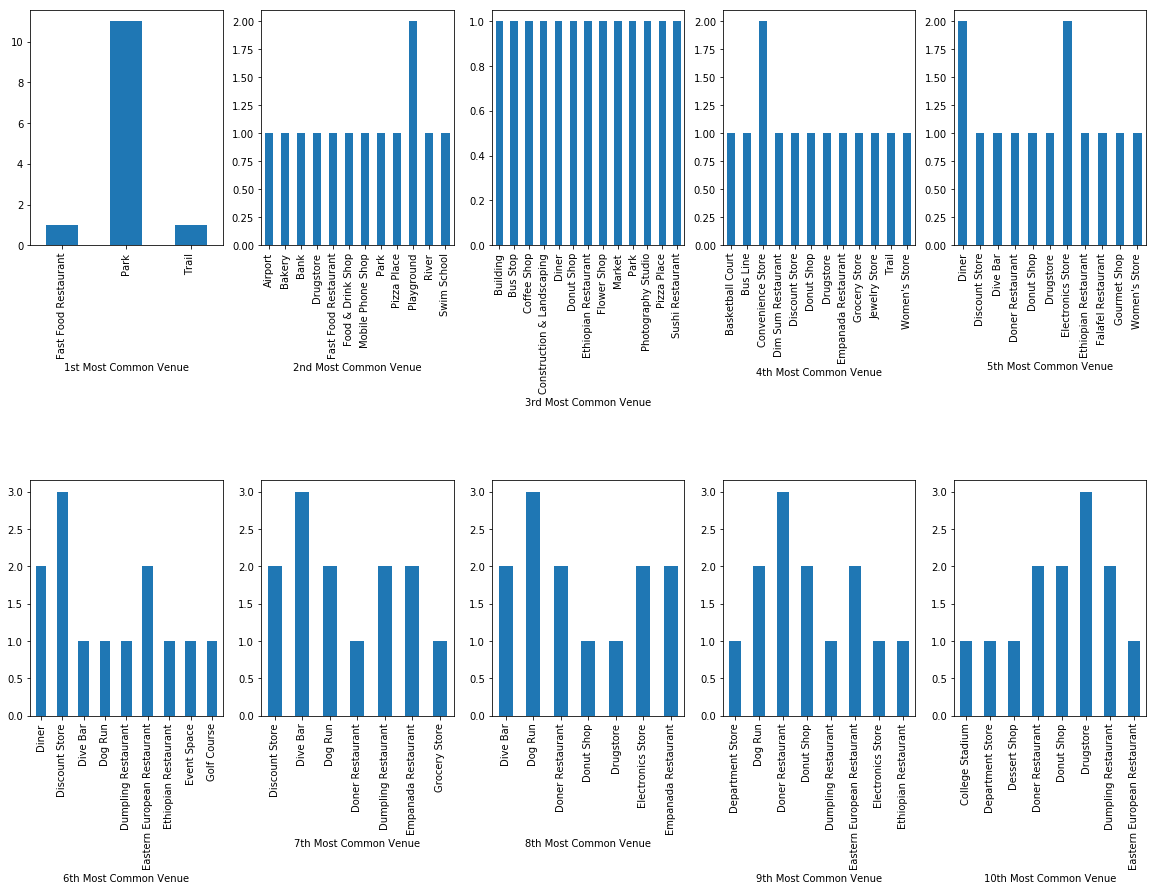

,Highest Frequency
Rank,
1st Most Common Venue,Park
2nd Most Commond Venue,Playground
3rd Most Common Venue,Building
4th Most Common Venue,Convenience Store
5th Most Common Venue,Diner
6th Most Common Venue,Discount Store
7th Most Common Venue,Dive Bar
8th Most Common Venue,Dog Run
9th Most Common Venue,Doner Restaurant


In [38]:

c1_df = pd.DataFrame(columns=['Highest Frequency'])
for i in range(6, 16, 1):
    cluster_counts = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].groupby(toronto_merged.iloc[:,i]).size()
    plt.subplot(2,5,i-5)
    cluster_counts.plot(kind='bar', figsize=(20,10))
    c1_df.loc[i-6] = cluster_counts.idxmax()

c1_df['Rank'] = indx    
c1_df.set_index('Rank', inplace=True)


plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.2)
plt.show()

c1_df

### Cluster 1

Looking closer at the data in the largest cluster, in the 1st to 4th most common venues, the venues with the highest frequency across all neighborhoods are coffee shops and cafes which have a drastically higher frequency when compared to the rest of the venues. Based on the data it is safe to assume that the defining characteristic in this cluster is neighborhoods that have coffee shops and cafes nearby. Based on this it makes sense that this cluster is large because there is generally a high density of coffee shops / cafes in urban areas and toronto is a large city.

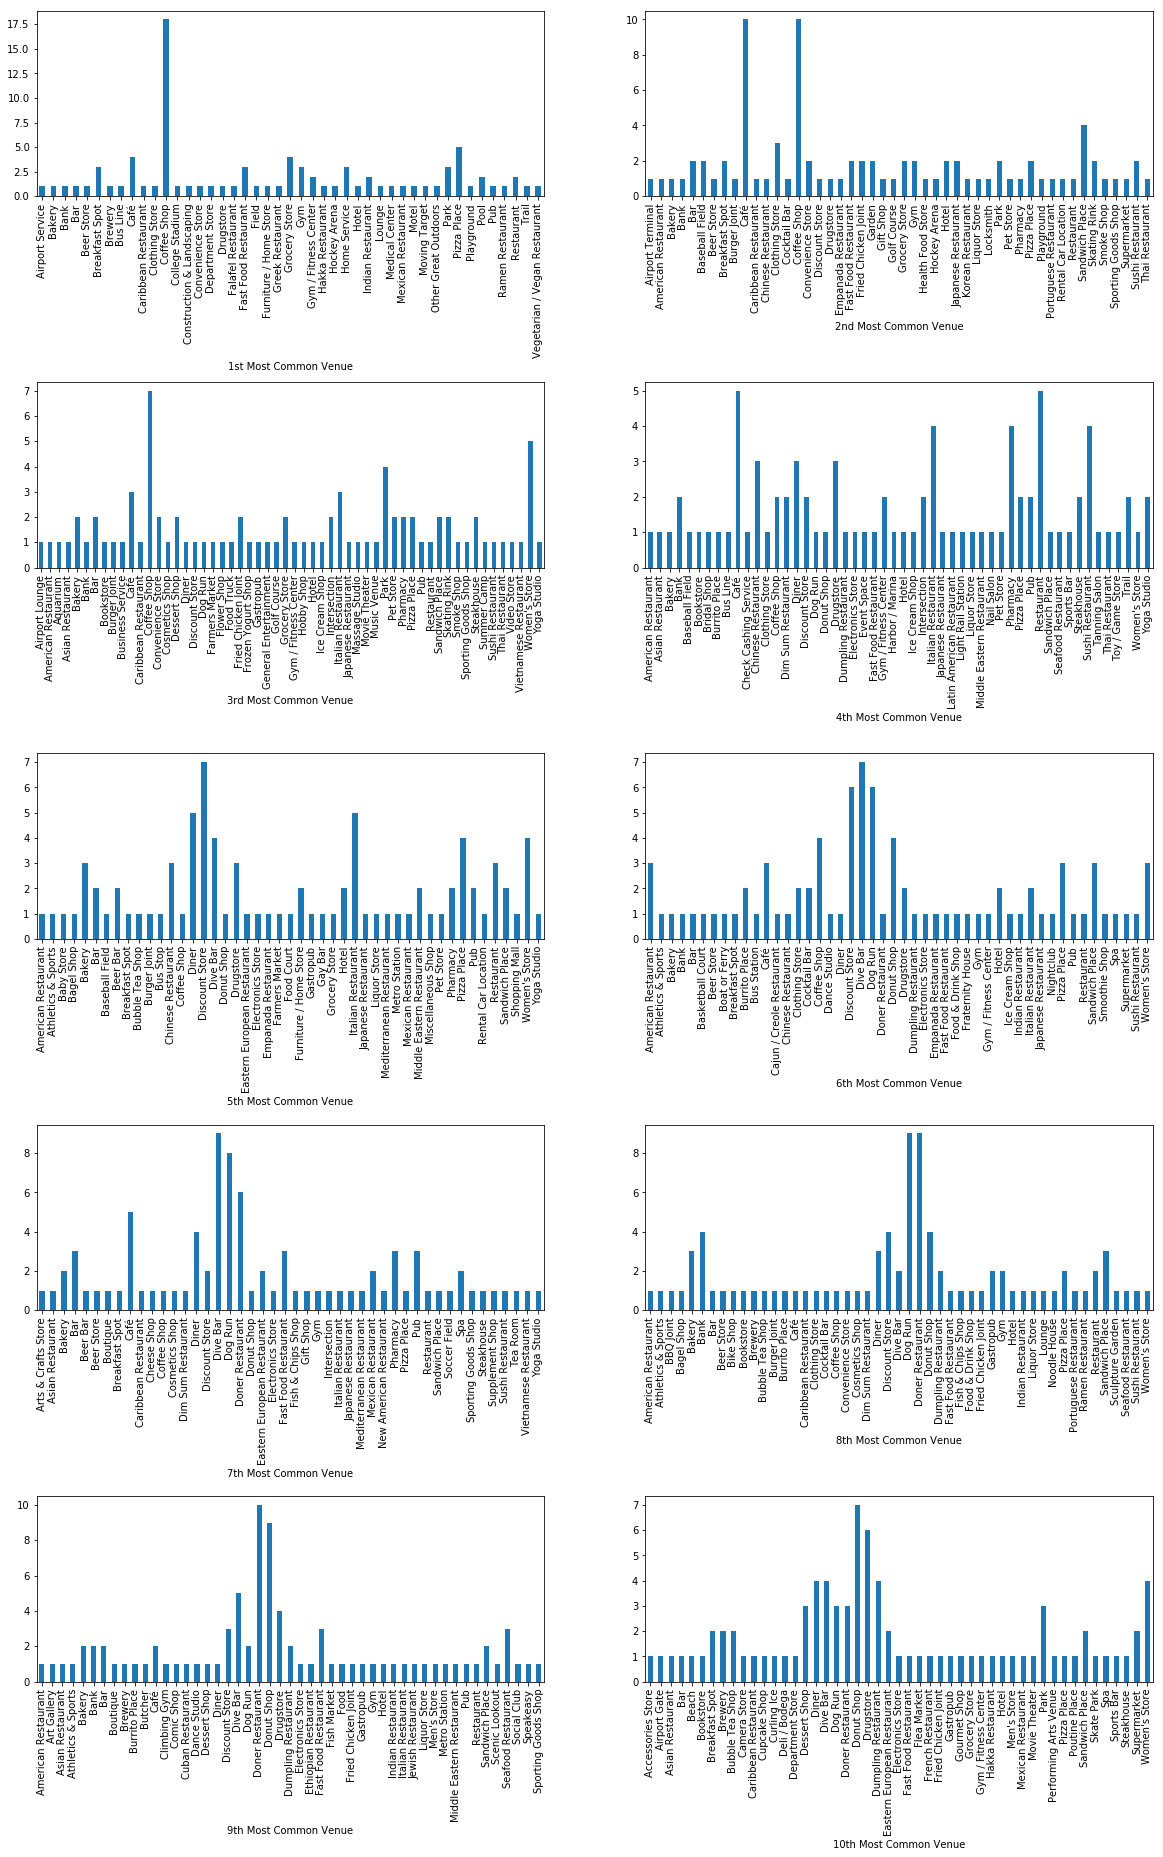

,Highest Frequency
Rank,
1st Most Common Venue,Coffee Shop
2nd Most Commond Venue,Café
3rd Most Common Venue,Coffee Shop
4th Most Common Venue,Café
5th Most Common Venue,Discount Store
6th Most Common Venue,Dive Bar
7th Most Common Venue,Dive Bar
8th Most Common Venue,Dog Run
9th Most Common Venue,Doner Restaurant


In [39]:
c2_df = pd.DataFrame(columns=['Highest Frequency'])
for i in range(6, 16, 1):
    cluster_counts = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1].groupby(toronto_merged.iloc[:,i]).size()
    plt.subplot(10,2,i-5)
    cluster_counts.plot(kind='bar', figsize=(20,50))
    c2_df.loc[i-6] = cluster_counts.idxmax()

c2_df['Rank'] = indx    
c2_df.set_index('Rank', inplace=True)


plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.2)
plt.show()

c2_df

### Cluster 2

The final cluster has only one neighborhood in it so it is not necessary to plot the frequency of venues in each neighborhood. Looking at the data it is safe to assume that the reason this neighborhood is in its own cluster is because neither parks nor coffee shops / cafes are in the 10 most common venues. It is in its own cluster because of dissimilarity between the other two clusters. 

In [40]:
c3_df = pd.DataFrame(columns=['Highest Frequency'])
for i in range(6, 16, 1):
    cluster_counts = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2].groupby(toronto_merged.iloc[:,i]).size()
    c3_df.loc[i-6] = cluster_counts.idxmax()

c3_df['Rank'] = indx    
c3_df.set_index('Rank', inplace=True)

c3_df

,Highest Frequency
Rank,
1st Most Common Venue,Cafeteria
2nd Most Commond Venue,Drugstore
3rd Most Common Venue,Diner
4th Most Common Venue,Discount Store
5th Most Common Venue,Dive Bar
6th Most Common Venue,Dog Run
7th Most Common Venue,Doner Restaurant
8th Most Common Venue,Donut Shop
9th Most Common Venue,Women's Store


The last step is to rename the cluster labels in the dataframe based on what the clusters represent.

Cluster 0 is neighborhoods that have parks nearby.

Cluster 1 is neighborhoods that have coffee shops / cafes nearby.

Cluster 3 is a different category that we will name "other"

In [41]:
toronto_merged['Cluster Labels'].replace(0, 'Parks', inplace=True)
toronto_merged['Cluster Labels'].replace(1, 'Coffee Shops / Cafes', inplace=True)
toronto_merged['Cluster Labels'].replace(2, 'Other', inplace=True)

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,Coffee Shops / Cafes,Fast Food Restaurant,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Hakka Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Coffee Shops / Cafes,Moving Target,Bar,Women's Store,Dim Sum Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Coffee Shops / Cafes,Medical Center,Breakfast Spot,Intersection,Electronics Store,Rental Car Location,Pizza Place,Mexican Restaurant,Doner Restaurant,Discount Store,Dive Bar
3,M1G,Scarborough,Woburn,43.770992,-79.216917,Coffee Shops / Cafes,Coffee Shop,Korean Restaurant,Pharmacy,Women's Store,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Coffee Shops / Cafes,Hakka Restaurant,Thai Restaurant,Fried Chicken Joint,Bank,Bakery,Athletics & Sports,Caribbean Restaurant,Lounge,Cuban Restaurant,Cupcake Shop
